<a href="https://colab.research.google.com/github/GargRaghav17/CIFAR-10_CNN_basic/blob/main/AE_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform = torchvision.transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,transform = torchvision.transforms.ToTensor(), download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 32839216.78it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # No max pooling after the third convolution in the encoder
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            # nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),

            # nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Upsample(scale_factor=2, mode='nearest'),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode='nearest'),

            nn.Conv2d(32,32,kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            # No upsampling after the last convolution in the decoder

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model_2 = Autoencoder().to(device)
model_2

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [5]:
# Create a loss fn
loss_fn = nn.MSELoss()

# Create optimizer
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001, weight_decay = 1e-6)

# Calculating accuracy, % of correct predictions
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

In [6]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_2.train()  # Set the model to training mode
    total_loss = 0.0
    # total_pixels = 0
    for inputs, _ in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        outputs = model_2(inputs)
        outputs = outputs.to(device)
        loss = loss_fn(outputs, inputs)

        total_loss += loss.item()
        # total_pixels += inputs.numel()
        # print(total_pixels)

        loss.backward()
        optimizer.step()


    average_loss = total_loss / len(train_loader)
    # percentage_loss = (average_loss/255**2)*100

    print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')

# Testing loop
model_2.eval()  # Set the model to evaluation mode
total_test_loss = 0.0
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model_2(inputs)
        outputs = outputs.to(device)
        test_loss = loss_fn(outputs, inputs)
        total_test_loss += test_loss.item()

average_test_loss = total_test_loss / len(test_loader)
print(f'Average Test Loss: {average_test_loss:.4f}')

Training Epoch [1/10], Average Loss: 0.0187
Training Epoch [2/10], Average Loss: 0.0074
Training Epoch [3/10], Average Loss: 0.0060
Training Epoch [4/10], Average Loss: 0.0052
Training Epoch [5/10], Average Loss: 0.0049
Training Epoch [6/10], Average Loss: 0.0047
Training Epoch [7/10], Average Loss: 0.0045
Training Epoch [8/10], Average Loss: 0.0044
Training Epoch [9/10], Average Loss: 0.0043
Training Epoch [10/10], Average Loss: 0.0041
Average Test Loss: 0.0040


In [7]:
'''
Training Epoch [1/10], Average Loss: 0.0176
Training Epoch [2/10], Average Loss: 0.0075
Training Epoch [3/10], Average Loss: 0.0058
Training Epoch [4/10], Average Loss: 0.0052
Training Epoch [5/10], Average Loss: 0.0048
Training Epoch [6/10], Average Loss: 0.0045
Training Epoch [7/10], Average Loss: 0.0044
Training Epoch [8/10], Average Loss: 0.0042
Training Epoch [9/10], Average Loss: 0.0040
Training Epoch [10/10], Average Loss: 0.0039
Average Test Loss: 0.0038
'''

'\nTraining Epoch [1/10], Average Loss: 0.0176\nTraining Epoch [2/10], Average Loss: 0.0075\nTraining Epoch [3/10], Average Loss: 0.0058\nTraining Epoch [4/10], Average Loss: 0.0052\nTraining Epoch [5/10], Average Loss: 0.0048\nTraining Epoch [6/10], Average Loss: 0.0045\nTraining Epoch [7/10], Average Loss: 0.0044\nTraining Epoch [8/10], Average Loss: 0.0042\nTraining Epoch [9/10], Average Loss: 0.0040\nTraining Epoch [10/10], Average Loss: 0.0039\nAverage Test Loss: 0.0038\n'

Original Image:


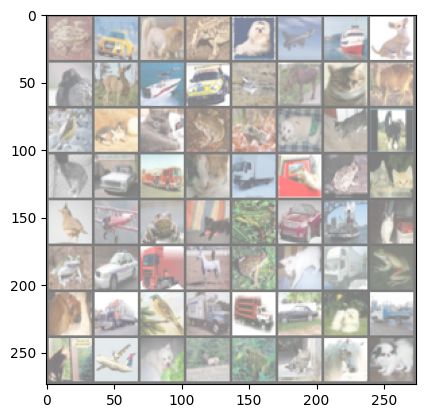

Reconstructed Image:


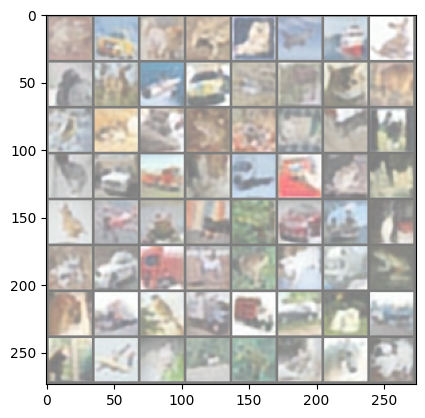

In [9]:
# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image (if it was normalized during loading)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Function to visualize original and reconstructed images
def visualize_images(model, data_loader, num_images=1):
    model.eval()
    data_iter = iter(data_loader)

    for _ in range(num_images):
        # Get a batch of data
        images, _ = next(data_iter)

        # Forward pass through the autoencoder
        recon_images = model(images)

        # Display original and reconstructed images
        print("Original Image:")
        imshow(torchvision.utils.make_grid(images))
        print("Reconstructed Image:")
        imshow(torchvision.utils.make_grid(recon_images.detach()))

# Visualize images using the autoencoder
visualize_images(model_2.to('cpu'), test_loader, num_images=1)
